# Yanny or Laurel

There's been an audio clip going around and there's a debate on whether the clip says "Yanny" or "Laurel". I personally hear "Yanny" easily but by trying to focus more, I can actually hear "Laurel" as well. The difference is that "Yanny" has higher pitch and "Laurel" is in a deep voice. In this notebook, we try to separate the two sounds in order to hear both names.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from IPython.display import Audio

%matplotlib inline

I have downloaded the [youtube video](https://www.youtube.com/watch?v=EXRoQGHx-80) as mp3 and then converted it to .wav format using the following command:

```!ffmpeg -i yanny_laurel.mp3 -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav yanny_laurel.wav```

You can listen to the file below:

In [2]:
yl = Audio('yanny_laurel.wav')
yl

We then read the .wav file into numpy array so that we can perform analysis on the data.

In [3]:
rate, yl_wav = wavfile.read('yanny_laurel.wav')
yl_wav

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

We visualize the sound waves. Notice three distinct areas that corresponds to the periods where you hear the speaker say the words.

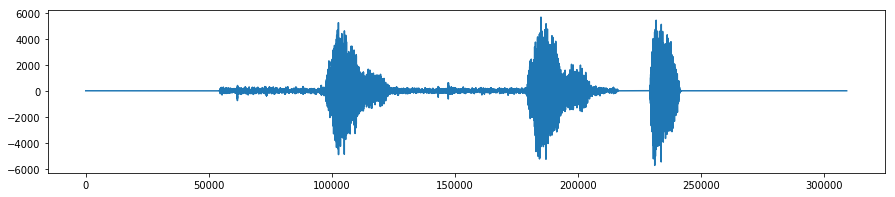

In [4]:
plt.figure(figsize=(15, 3))
plt.plot(yl_wav);

We slice the data so that we only keep the two instances where the speaker mentions the words.

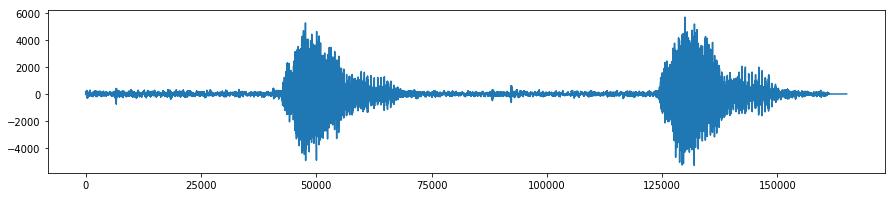

In [5]:
yl_new = yl_wav[55000:220000]
plt.figure(figsize=(15, 3))
plt.plot(yl_new)

### Can we separate the two sounds?

From the visualization above, it's hard to see how we can separate the two words. We perform Fast Fourier Transform and visualize the result in order to see if we can find some patterns from the frequencies.

/Users/User/anaconda3/envs/msds/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


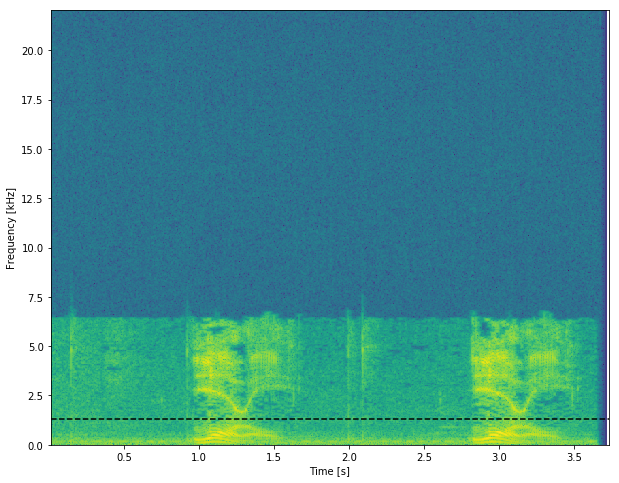

In [6]:
from scipy import signal

freqs, times, Sx = signal.spectrogram(yl_new, fs=rate, window='hanning',
                                      nperseg=1000, noverlap=800,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(10, 8))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')

split = 1.3

ax.axhline(split, color='k', linestyle='--')
ax.set_xlabel('Time [s]');

From the image, we notice that there seems to be gap around 1.3kHz. We then create two arrays: (1) One that only allows low frequency sounds below 1.3kHz, and (2) only allows sounds above 1.3kHz. We do this using filters on the signal which I got from [this](https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units) stackoverflow post and adding a parameter for either high pass or low pass filter.

In [7]:
from scipy.signal import butter, lfilter, freqz

def butter_pass(cutoff, fs, btype, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

def butter_pass_filter(data, cutoff, fs, order=5, btype='low'):
    b, a = butter_pass(cutoff, fs, btype=btype, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = rate      # sample rate, Hz
cutoff = split * 1000  # desired cutoff frequency of the filter, Hz

In [8]:
y_yanny = butter_pass_filter(yl_new, cutoff, fs, order, btype='low')
Audio(y_yanny, rate=rate)

In [9]:
y_yanny = butter_pass_filter(yl_new, cutoff + 1000, fs, order, btype='high')
Audio(y_yanny, rate=rate)

Note that we increased the cutoff frequency the second one to make the "yanny" word more audible.